# Régression sans inversion

Ce notebook mesure le temps de calcul dans deux algorithmes pour résoudre une régression linéaire, le premier inverse un matrice, le second le fait sans inverser une matrice, le troisième reprend l'idée du second mais utilise une décomposition [QR](https://fr.wikipedia.org/wiki/D%C3%A9composition_QR) puis inverse la matrice *R*.

In [1]:
%matplotlib inline

In [2]:
import numpy.random as rnd

X = rnd.randn(1000, 7)
eps = rnd.randn(1000, 1) / 3
y = X.sum(axis=1).reshape((X.shape[0], 1)) + eps
y = y.ravel()
X.shape, y.shape, eps.shape

((1000, 7), (1000,), (1000, 1))

In [3]:
from mlstatpy.ml.matrices import linear_regression, gram_schmidt

beta1 = linear_regression(X, y, algo=None)
beta2 = linear_regression(X, y, algo="gram")
beta1, beta2

(array([0.97915374, 1.00078055, 1.00537618, 1.01021414, 1.0003261 ,
        0.9944518 , 0.98742625]),
 array([0.97915374, 1.00078055, 1.00537618, 1.01021414, 1.0003261 ,
        0.9944518 , 0.98742625]))

In [4]:
%timeit linear_regression(X, y, algo=None)

38.4 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
%timeit linear_regression(X, y, algo="gram")

310 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%timeit linear_regression(X, y, algo="qr")

139 µs ± 8.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
Xt = X.T
%timeit gram_schmidt(Xt)

210 µs ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Un exemple avec [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [8]:
from sklearn.linear_model import LinearRegression

clr = LinearRegression()
%timeit clr.fit(X, y)

443 µs ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Qui utilise la fonction [lstsq](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html?highlight=lstsq):

In [9]:
from numpy.linalg import lstsq

%timeit lstsq(X, y, rcond=None)

75.5 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Il serait sans doute possible d'optimiser les calculs en réduisant le nombre de copie et de transposées. La version utilisant une décomposition [QR](https://fr.wikipedia.org/wiki/D%C3%A9composition_QR) est assez rapide. Le code est là [matrices.py](https://github.com/sdpython/mlstatpy/blob/main/mlstatpy/ml/matrices.py). Pour dépasser [numpy](https://www.numpy.org/), il faut passer au C++. *scikit-learn* ajoute des étapes intermédiaires pour vérifier les données ce qui explique la longueur. On résume le tout par un graphique.

In [10]:
from onnx_array_api.ext_test_case import measure_time

In [11]:
stmts = [
    dict(name="lr_matrix", fct="linear_regression(X, y, algo=None)"),
    dict(name="lr_gram", fct="linear_regression(X, y, algo='gram')"),
    dict(name="lr_qr", fct="linear_regression(X, y, algo='qr')"),
    dict(name="gram", fct="gram_schmidt(Xt)"),
    dict(name="sklearn", fct="clr.fit(X, y)"),
    dict(name="lstsq", fct="lstsq(X, y)"),
]

memo = []
for size, dim in [
    (100, 10),
    (1000, 10),
    (10000, 10),
    (100, 20),
    (1000, 20),
    (10000, 20),
    (100, 50),
    (1000, 50),
]:
    print(size, dim)
    X = rnd.randn(size, dim)
    eps = rnd.randn(size, 1) / 3
    y = X.sum(axis=1).reshape((X.shape[0], 1)) + eps
    y = y.ravel()
    context = dict(
        linear_regression=linear_regression,
        Xt=X.T,
        X=X,
        y=y,
        gram_schmidt=gram_schmidt,
        clr=clr,
        lstsq=lambda X, y: lstsq(X, y, rcond=None),
    )

    for stmt in stmts:
        res = measure_time(
            stmt["fct"], number=20, repeat=20, div_by_number=True, context=context
        )
        res.update(stmt)
        res["size"] = size
        res["dim"] = dim
        memo.append(res)

import pandas

df = pandas.DataFrame(memo)
df.head()

100 10
1000 10
10000 10
100 20
1000 20
10000 20
100 50
1000 50


,average,context_size,deviation,dim,fct,max_exec,min_exec,name,number,repeat,size
0,0.000039,368,0.000019,10,"linear_regression(X, y, algo=None)",0.000091,0.000018,lr_matrix,20,20,100
1,0.000365,368,0.000045,10,"linear_regression(X, y, algo='gram')",0.000485,0.000312,lr_gram,20,20,100
2,0.000114,368,0.000031,10,"linear_regression(X, y, algo='qr')",0.000223,0.000093,lr_qr,20,20,100
3,0.000229,368,0.000020,10,gram_schmidt(Xt),0.000256,0.000197,gram,20,20,100
4,0.000403,368,0.000031,10,"clr.fit(X, y)",0.000464,0.000346,sklearn,20,20,100


In [12]:
piv = pandas.pivot_table(df, index=["size", "dim"], columns="name", values="average")
piv

name           gram   lr_gram  lr_matrix     lr_qr     lstsq   sklearn
size  dim                                                             
100   10   0.000229  0.000365   0.000039  0.000114  0.000081  0.000403
      20   0.000442  0.000772   0.000057  0.000142  0.000143  0.000433
      50   0.001384  0.002303   0.000115  0.000298  0.000619  0.000935
1000  10   0.000335  0.000498   0.000052  0.000168  0.000140  0.000633
      20   0.000867  0.001197   0.000093  0.000335  0.000246  0.000641
      50   0.003242  0.004482   0.000263  0.001220  0.000945  0.001545
10000 10   0.001434  0.001309   0.000234  0.002760  0.000551  0.001828
      20   0.010212  0.010944   0.000293  0.005926  0.002128  0.005581

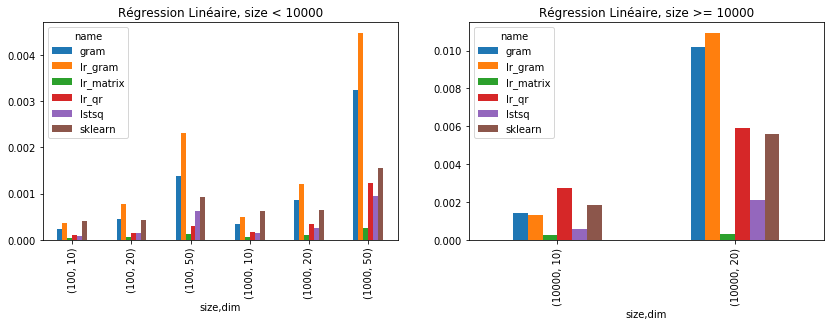

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
piv[:6].plot(kind="bar", ax=ax[0])
piv[6:].plot(kind="bar", ax=ax[1])
ax[0].set_title("Régression Linéaire, size < 10000")
ax[1].set_title("Régression Linéaire, size >= 10000");

## Streaming versions

L'idée est différente ici puisqu'il s'agit de calculer toutes les régressions linéaires intermédiaires. Les algorithmes sont décrits par l'exposé [Régression linéaire par morceaux](find://l-reglin-piecewise-streaming).

In [14]:
from mlstatpy.ml.matrices import (
    streaming_linear_regression,
    streaming_linear_regression_gram_schmidt,
)


def all_linear_regression(X, y):
    for i in range(X.shape[1], X.shape[0]):
        yield linear_regression(X[:i], y[:i])


stmts = [
    dict(name="lr_matrix", fct="list(all_linear_regression(X, y))"),
    dict(name="lr_st_mat", fct="list(streaming_linear_regression(X, y))"),
    dict(name="lr_st_gram", fct="list(streaming_linear_regression_gram_schmidt(X, y))"),
]

memo = []
for dim in (10,):
    for size in range(100, 3500, 500):
        print(size, dim)
        X = rnd.randn(size, dim)
        eps = rnd.randn(size, 1) / 3
        y = X.sum(axis=1).reshape((X.shape[0], 1)) + eps
        y = y.ravel()
        context = dict(
            X=X,
            y=y,
            all_linear_regression=all_linear_regression,
            streaming_linear_regression=streaming_linear_regression,
            streaming_linear_regression_gram_schmidt=streaming_linear_regression_gram_schmidt,
        )

        for stmt in stmts:
            if "gram" in stmt["name"]:
                nn = 1
                if size >= 1000:
                    continue
            else:
                nn = 5
            res = measure_time(
                stmt["fct"], number=nn, repeat=nn, div_by_number=True, context=context
            )
            res.update(stmt)
            res["size"] = size
            res["dim"] = dim
            memo.append(res)

import pandas

df = pandas.DataFrame(memo)
df.head()

100 10
600 10
1100 10
1600 10
2100 10
2600 10
3100 10


,average,context_size,deviation,dim,fct,max_exec,min_exec,name,number,repeat,size
0,0.002589,368,0.001263,10,"list(all_linear_regression(X, y))",0.005070,0.001753,lr_matrix,5,5,100
1,0.002621,368,0.000038,10,"list(streaming_linear_regression(X, y))",0.002688,0.002572,lr_st_mat,5,5,100
2,0.031022,368,0.000000,10,list(streaming_linear_regression_gram_schmidt(...,0.031022,0.031022,lr_st_gram,1,1,100
3,0.018594,368,0.000749,10,"list(all_linear_regression(X, y))",0.019532,0.017664,lr_matrix,5,5,600
4,0.022098,368,0.001805,10,"list(streaming_linear_regression(X, y))",0.024896,0.020070,lr_st_mat,5,5,600


In [15]:
piv = pandas.pivot_table(df, index=["size"], columns="name", values="average")
piv

name,lr_matrix,lr_st_gram,lr_st_mat
size,,,
100,0.002589,0.031022,0.002621
600,0.018594,0.204768,0.022098
1100,0.040404,NaN,0.034072
1600,0.062186,NaN,0.052658
2100,0.097438,NaN,0.060824
2600,0.128451,NaN,0.079594
3100,0.161074,NaN,0.090113


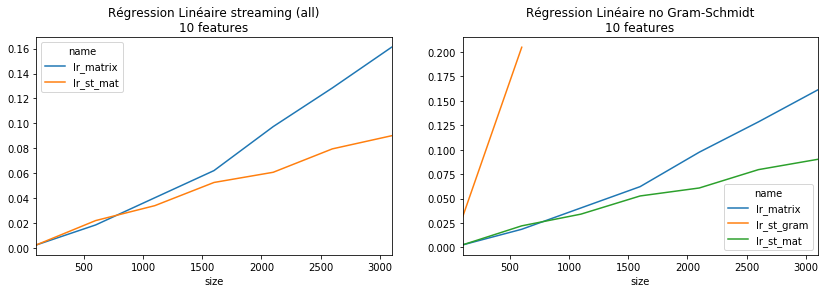

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
piv[["lr_matrix", "lr_st_mat"]].plot(ax=ax[0])
piv.plot(ax=ax[1])
ax[0].set_title("Régression Linéaire streaming (all)\n10 features")
ax[1].set_title("Régression Linéaire no Gram-Schmidt\n10 features");

La version streaming devient plus intéressante à partir de 1000 observations, le coût en linéaire en *N* contrairement à la version classique qui est en $N^2$. La version Gram-Schmidt devrait être réécrite en C++ pour proposer des temps comparables.